# Детекция спама

## Импорты / функции / константы

In [1]:
%%capture
!pip install unidecode
!pip install wordcloud
!pip install fasttext
!pip install scikit-plot
!pip install textblob

In [2]:
from typing import List
import random
import pandas as pd
import numpy as np
import joblib
from joblib import Parallel, delayed
import multiprocessing

import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode
from textblob import TextBlob

import fasttext
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import scikitplot as splt
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.6f}'.format
plt.rcParams['figure.figsize'] = (6, 3)
%config InlineBackend.figure_format='retina'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
STOPWORDS = list(stopwords.words("english"))
STOPWORDS.extend([
    'ect', 'hou', 'subject', 'org',
    'cc', 'com', 'url', 'would', 'pm',
])

COLOR = '#0077ff'

In [4]:
def check_spelling_light(text: str) -> str:
  """Исправляет опечатки (TextBlob)."""
  tokens = text.split()
  checked_tokens = []
  for tok in tokens:
    tb = TextBlob(tok)
    checked_tok = tb.correct()
    checked_tokens.append(checked_tok)

  checked_text = ' '.join(map(str, checked_tokens))
  return checked_text

def preprocess_text_light(text: str) -> str:
  """
  Выполняет предобработку исходного текста:
    - лемматизация
    - удаление пунктуации (в т.ч. эмоджи);
    - удаление стоп-слов;
    - удаление чисел;
    - удаление токенов с небуквенными символами;
    - удаление токенов, равных 1 букве. (NLTK)
  """

  tokens = word_tokenize(check_spelling_light(unidecode(text)))
  lemmatizer = WordNetLemmatizer()
  tokens_lst = [
      lemmatizer.lemmatize(token) for token in tokens if
      (token not in string.punctuation)
      & (token not in STOPWORDS)
      & (not token.isdigit())
      & (token.isalpha())
      & (len(token) > 1)
  ]
  text_preproc = ' '.join(tokens_lst)
  return text_preproc

def clf_report(clf_name: str, y_true: pd.Series, y_pred: np.array, y_pred_proba: np.array) -> pd.DataFrame:
  """
  Выводит репорт по качеству классификации, который включает
  метрики roc-auc, precision, recall, f1-score.
  """

  return pd.DataFrame(
      {
          'ROC AUC': roc_auc_score(y_true, y_pred_proba),
          'Precision': precision_score(y_true, y_pred),
          'Recall': recall_score(y_true, y_pred),
          'F1': f1_score(y_true, y_pred),
      },
      index=[clf_name]
  )

def fixed_word_color(*args, **kwargs):
  """Фиксирует цвет текста для облака слов."""
  return 'cyan'

## Загрузка данных + EDA

In [ ]:
train_df = pd.read_csv('train_spam.csv')
display(train_df.head(3))
print(train_df.shape)

test_df = pd.read_csv('test_spam.csv')
display(test_df.head(3))
print(test_df.shape)

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...


(16278, 2)


,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...


(4070, 1)


In [ ]:
plt.figure(figsize=(6, 3))

ax = sns.countplot(
    data=train_df,
    x='text_type',
    color=COLOR,
    width=0.5
)

ax.set_yticks([])
ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)
ax.set_ylabel('')
sns.despine(ax=ax, left=True, right=True, top=True)

train_len = train_df.shape[0]
for p in ax.patches:
  h = p.get_height()
  perc_from_total = (h / train_len) * 100

  ax.annotate(
      f'{perc_from_total:.2f}%',
      (p.get_x() + p.get_width() / 2., h),
      ha='center', va='bottom',
      color='gray', fontsize=10,
      xytext=(0, 3),
      textcoords='offset points'
  )

plt.title(
    'Распределение целевой переменной',
    pad=15, color='gray', fontsize=12,
);



---

В данных наблюдается дисбаланс классов. Категория «не спам» преобладает по сравнению с классом «спам». Нормальные письма составляют __70,46%__ от общего объема данных, а спамные — __29,54%__.

Чтобы учесть влияние дибаланса классов на производительность моделей, кроме ROC-AUC, будем оценивать распределение ошибок по confusion matrix и F1-меру.

Стратегии балансировки данных использоваться не будут, поскольку неравномерное распределение классов отражает типичную струкутру данных в реальных сценариях классификации спам/не спам.

---



In [ ]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
train_df_spam = train_df[train_df['text_type'] == 'spam']
train_df_ham = train_df[train_df['text_type'] == 'ham']

median_length_spam = train_df_spam['text_length'].describe()['50%']
median_length_ham = train_df_ham['text_length'].describe()['50%']

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(
  data=train_df_ham,
  x='text_length',
  label='ham',
  color=COLOR
)
sns.histplot(
  data=train_df_spam,
  x='text_length',
  label='spam',
  color='cyan'
)
sns.despine(right=True, top=True)
plt.title(
    'Распределение длины текста',
    pad=15, color='gray', fontsize=15,
)
plt.axvline(median_length_ham, linewidth=2)
plt.text(median_length_ham - 5, plt.ylim()[1]*.8, f'median={int(median_length_ham)}', color=COLOR, fontsize=10, rotation='vertical')

plt.axvline(median_length_spam, color='cyan', linewidth=2)
plt.text(median_length_spam + 1, plt.ylim()[1]*.8, f'median={int(median_length_spam)}', color='cyan', fontsize=10, rotation='vertical')

plt.legend();



---

График распределения длины текста в двух категориях писем построен на основе показателя количества псевдотокенов в каждом из текстов в каждом из классов.

1. Обычные письма (`ham`):

В основном сосредоточены в диапазоне до 10 псевдотокенов, и медианное значение длины сообщения также меньше.
Заметен значительный пик в распределении длины текста писем из категории «не спам» в диапазоне примерно от 130 до 150 псевдотокенов. Это может быть связано с особенностями конкретных данных или с общими особенностями писем на почте (напр., они могут быть более официальными (=длинными) или более неформальными (=короткими)).

2. Спам-письма (`spam`):

Медиана длин писем из категории «спам» больше, чем у неспамных писем, и имеется заметный пик в распределении примерно на отметке в 25 псевдотокенов.
Тем не менее, наблюдается тенденция к разнообразию объемов текста в спам-письмах, хоть и менее выраженная, чем у обычных писем.

---





In [ ]:
train_df['text__lst'] = train_df['text'].apply(lambda x: x.split())

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

for i, text_type in enumerate(['spam', 'ham']):
  toks = train_df.loc[train_df.text_type == text_type, 'text__lst'].explode().values

  wc = WordCloud(
      background_color=COLOR,
      color_func=fixed_word_color,
      collocations=False,
      width=1600,
      height=800
  )
  wc.generate(' '.join(toks))

  axes[i].imshow(wc)
  axes[i].set_title(f'{text_type}', pad=15, color='gray',  fontsize=22)
  axes[i].axis('off')

plt.tight_layout();



---

Облака слов демонстрируют, что тексты из категории «спам» в основном содержат слова, связанные с рекламными предложениями различных товаров, услуг или контента. А по наиболее частотным словам из текстов, отнесенных к категории «не спам», можно предположить, что нормальные письма — это выборка из корпоративной переписки.

---



## Подготовка данных

### Препроцессинг

In [ ]:
train_df.columns

Index(['text_type', 'text'], dtype='object')

In [ ]:
train_df['text_type'] = train_df['text_type'].map({'spam': 1, 'ham': 0})

In [ ]:
train_df['text__preproc'] = train_df['text'].progress_apply(preprocess_text_light)
# train_df.to_csv('train_preproc.csv', index=False)

  0%|          | 0/16278 [00:00<?, ?it/s]

In [ ]:
test_df['text__preproc'] = test_df['text'].progress_apply(preprocess_text_light)
# test_df.to_csv('test_preproc.csv', index=False)

In [9]:
# Загрузка данных с предобработкой
train_df = pd.read_csv('train_preproc.csv')

In [10]:
train_df['text_type'] = train_df['text_type'].map({'spam': 1, 'ham': 0})
train_df['text__preproc'] = train_df['text__preproc'].apply(lambda x: pd.NA if len(x.split()) == 0 else x)
train_df = train_df.dropna()

In [12]:
# проверка изменения соотношения ham/spam
train_df.text_type.value_counts(normalize=True)

text_type
0   0.703464
1   0.296536
Name: proportion, dtype: float64

In [ ]:
spam_tokens = [token for text in train_df.loc[train_df.text_type == 1, 'text__preproc'] for token in text.split()]
spam_top20tokens = nltk.FreqDist(spam_tokens).most_common(20)

spam_top20tokens_df = pd.DataFrame(
        data=spam_top20tokens,
        columns=['spam_token', 'count']
    )
spam_top20tokens_df.style.hide(axis='index')

In [ ]:
ham_tokens = [token for text in train_df.loc[train_df.text_type == 0, 'text__preproc'] for token in text.split()]
ham_top20tokens = nltk.FreqDist(ham_tokens).most_common(20)

ham_top20tokens_df = pd.DataFrame(
        data=ham_top20tokens,
        columns=['ham_token', 'count']
    )
ham_top20tokens_df.style.hide(axis='index')

In [15]:
X = train_df['text__preproc']
y = train_df['text_type']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=8)

### Векторизация

#### 1 _ TfidfVectorizer

In [17]:
tfidf_vectorizer = TfidfVectorizer(min_df=50)

In [18]:
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_train_vectorized = pd.DataFrame(
    data=X_train_vectorized.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

X_test_vectorized = tfidf_vectorizer.transform(X_test)
X_test_vectorized = pd.DataFrame(
    data=X_test_vectorized.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [19]:
sc = MinMaxScaler()

X_train_scaled = pd.DataFrame(sc.fit_transform(X_train_vectorized), columns=X_train_vectorized.columns.tolist())
X_test_scaled = pd.DataFrame(sc.transform(X_test_vectorized), columns=X_test_vectorized.columns.tolist())

#### 2 _ FastText

In [20]:
train_data_ft = pd.concat([X_train.apply(lambda x: re.sub('\t', '', x)),
                           y_train.apply(lambda x: '__label__' + str(x))], axis=1)
test_data_ft = pd.concat([X_test.apply(lambda x: re.sub('\t', '', x)),
                          y_test.apply(lambda x: '__label__' + str(x))], axis=1)

train_data_ft.to_csv('train_data_ft.txt', sep='\t', header=None, index=None)
test_data_ft.to_csv('test_data_ft.txt', sep='\t', header=None, index=None)

In [21]:
ft_model = fasttext.train_supervised(
    input='train_data_ft.txt',
    minCount=5,
    minn=3,
    maxn=5,
    wordNgrams=2,
    dim=150
)

In [22]:
X_train_ft = pd.DataFrame(
    data=X_train.apply(lambda x: ft_model.get_sentence_vector(x)).tolist(),
    columns=[f'v_{i+1}' for i in range(150)]
)
X_test_ft = pd.DataFrame(
    data=X_test.apply(lambda x: ft_model.get_sentence_vector(x)).tolist(),
    columns=[f'v_{i+1}' for i in range(150)]
)

In [23]:
sc = MinMaxScaler()

X_train_ftscaled = pd.DataFrame(sc.fit_transform(X_train_ft), columns=X_train_ft.columns.tolist())
X_test_ftscaled = pd.DataFrame(sc.transform(X_test_ft), columns=X_test_ft.columns.tolist())

## Baseline модели


__План__

1. Обучить 5 моделей с гиперпараметрами по умолчанию сначала на Tfidf-векторах, затем на эмбеддингах fasttext, которые обучались по supervised стратегии.

  __*Модели*__
   - Multinomial Naive Bayes
   - SVM
   - Logistic Regression
   - Random Forest
   - Gradient Boosting

2. Оценить качество каждой модели по confusion matrix и метрикам Precision, Recall, F1-score, ROC-AUC.

3. Проанализировать полученные показатели мерик качества:

- одинаковых моделей, обученных на разных признаках;
- разных моделей.

4. Выбрать лучшие модели, подобрать для них по сетке оптимальные гиперпараметры и сравнить между собой.

5. Сделать скоринг тестовой выборки лучшей моделью.




### 1 - MultinomialNB

In [37]:
mnb = MultinomialNB()
mnb.fit(X_train_scaled, y_train)

mnb_pred = mnb.predict(X_test_scaled)
mnb_probs = mnb.predict_proba(X_test_scaled)[:, 1]

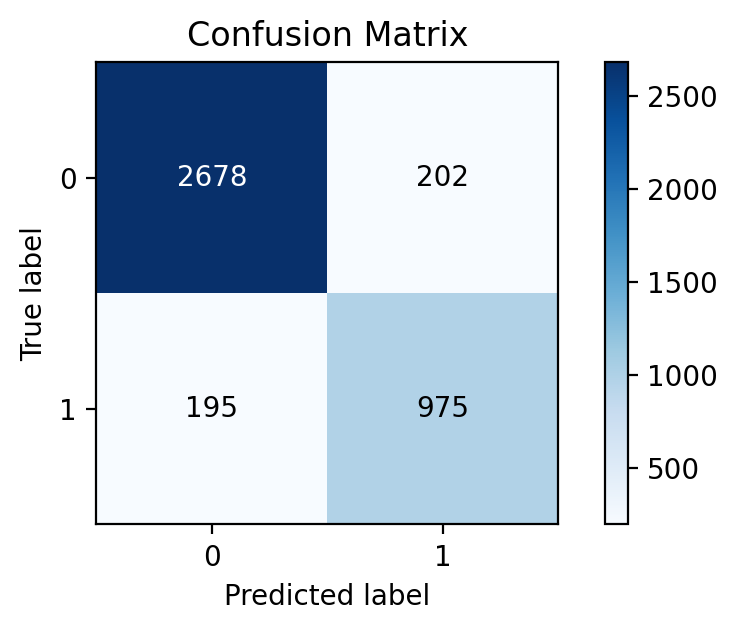

,ROC AUC,Precision,Recall,F1
Multinomial NB + Tfidf,0.955759,0.828377,0.833333,0.830848


In [38]:
plt.show(splt.metrics.plot_confusion_matrix(y_test, mnb_pred))
clf_report('Multinomial NB + Tfidf', y_test, mnb_pred, mnb_probs)

In [39]:
mnb2 = MultinomialNB()
mnb2.fit(X_train_ftscaled, y_train)

mnb2_pred = mnb2.predict(X_test_ftscaled)
mnb2_probs = mnb2.predict_proba(X_test_ftscaled)[:, 1]

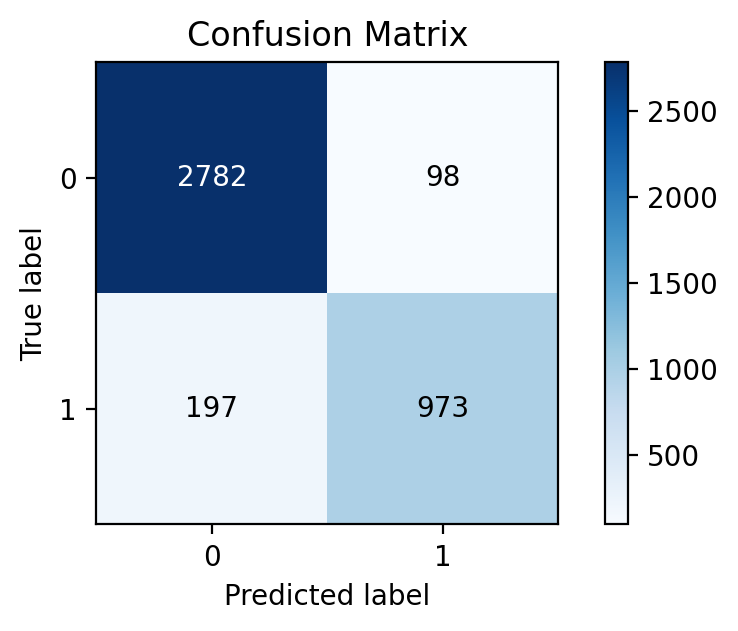

,ROC AUC,Precision,Recall,F1
Multinomial NB + FastText,0.966971,0.908497,0.831624,0.868362


In [40]:
plt.show(splt.metrics.plot_confusion_matrix(y_test, mnb2_pred))
clf_report('Multinomial NB + FastText', y_test, mnb2_pred, mnb2_probs)

### 2 - SVM

In [24]:
svc = SVC(probability=True)
svc.fit(X_train_scaled, y_train)

svc_pred = svc.predict(X_test_scaled)
svc_probs = svc.predict_proba(X_test_scaled)[:, 1]

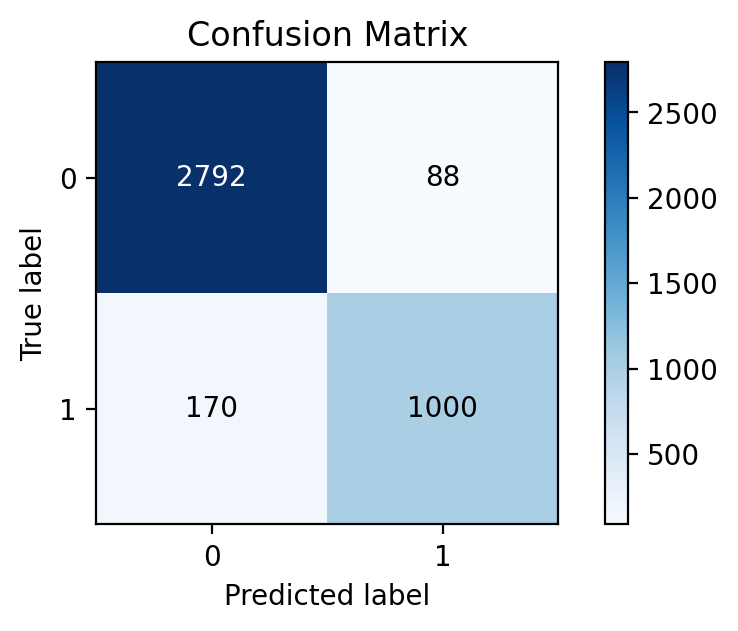

,ROC AUC,Precision,Recall,F1
SVC + Tfidf,0.971844,0.919118,0.854701,0.885740


In [25]:
plt.show(splt.metrics.plot_confusion_matrix(y_test, svc_pred))
clf_report('SVC + Tfidf', y_test, svc_pred, svc_probs)

In [26]:
svc2 = SVC(probability=True)
svc2.fit(X_train_ftscaled, y_train)

svc2_pred = svc2.predict(X_test_ftscaled)
svc2_probs = svc2.predict_proba(X_test_ftscaled)[:, 1]

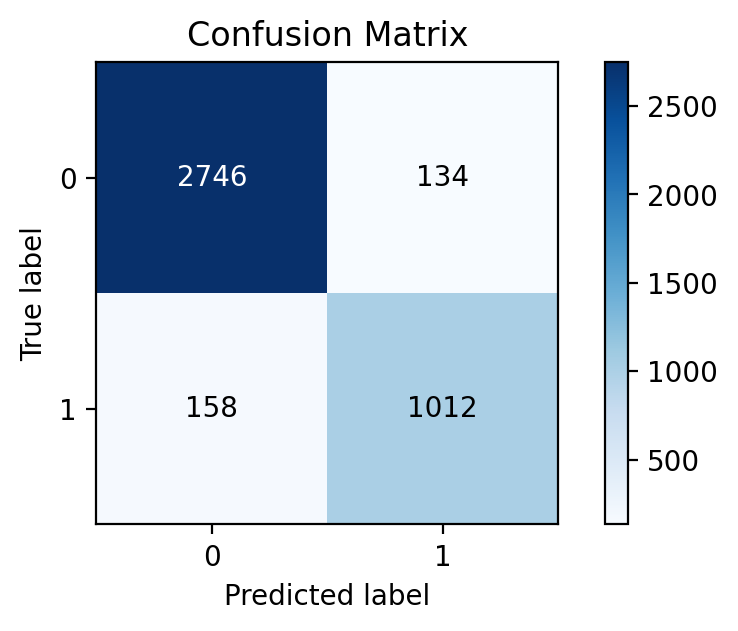

,ROC AUC,Precision,Recall,F1
SVC + FastText,0.966755,0.883072,0.864957,0.873921


In [27]:
plt.show(splt.metrics.plot_confusion_matrix(y_test, svc2_pred))
clf_report('SVC + FastText', y_test, svc2_pred, svc2_probs)

### 3 - Логистическая регрессия

In [45]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]

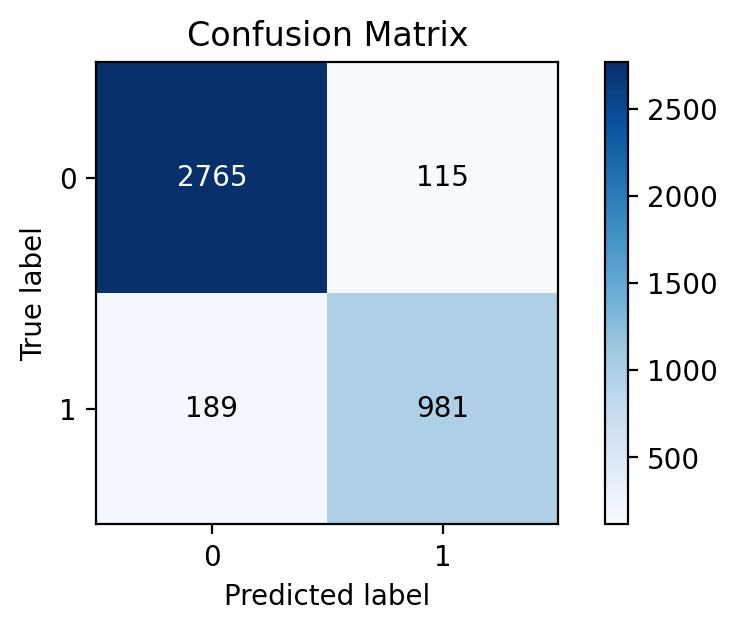

,ROC AUC,Precision,Recall,F1
Logistic Regression + Tfidf,0.970593,0.895073,0.838462,0.865843


In [46]:
plt.show(splt.metrics.plot_confusion_matrix(y_test, lr_pred))
clf_report('Logistic Regression + Tfidf', y_test, lr_pred, lr_probs)

In [47]:
lr2 = LogisticRegression()
lr2.fit(X_train_ftscaled, y_train)

lr2_pred = lr2.predict(X_test_ftscaled)
lr2_probs = lr2.predict_proba(X_test_ftscaled)[:, 1]

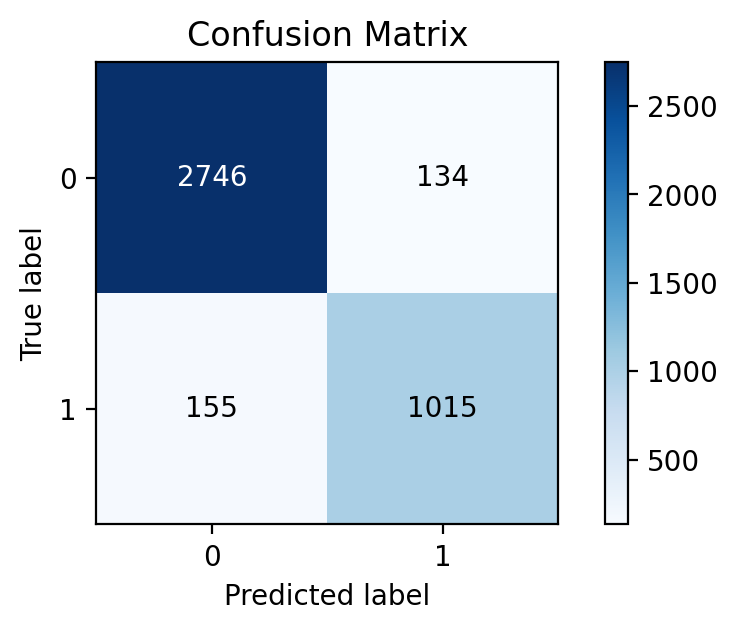

,ROC AUC,Precision,Recall,F1
Logistic Regression + FastText,0.967007,0.883377,0.867521,0.875377


In [48]:
plt.show(splt.metrics.plot_confusion_matrix(y_test, lr2_pred))
clf_report('Logistic Regression + FastText', y_test, lr2_pred, lr2_probs)

### 4 - Random Forest

In [28]:
rf = RandomForestClassifier(random_state=8)
rf.fit(X_train_vectorized, y_train)

rf_pred = rf.predict(X_test_vectorized)
rf_probs = rf.predict_proba(X_test_vectorized)[:, 1]

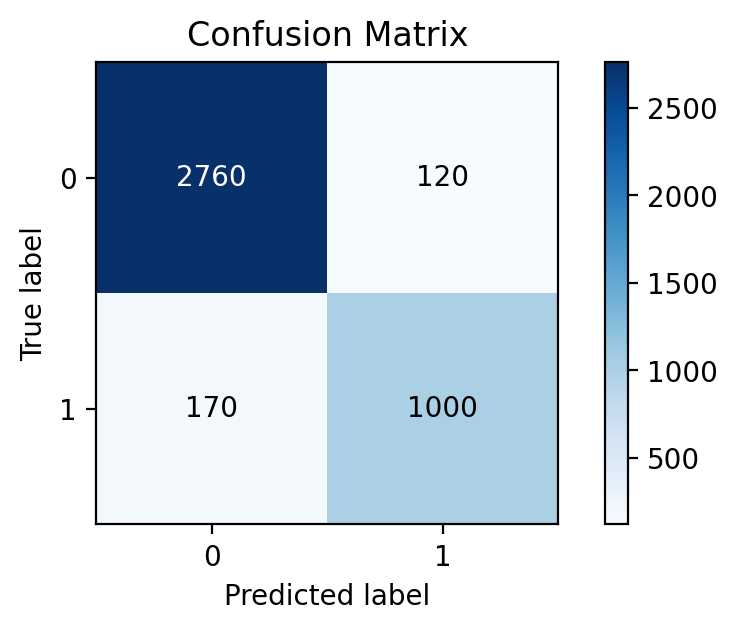

,ROC AUC,Precision,Recall,F1
Random Forest + Tfidf,0.965193,0.892857,0.854701,0.873362


In [29]:
plt.show(splt.metrics.plot_confusion_matrix(y_test, rf_pred))
clf_report('Random Forest + Tfidf', y_test, rf_pred, rf_probs)

In [30]:
rf2 = RandomForestClassifier(random_state=8)
rf2.fit(X_train_ft, y_train)

rf2_pred = rf2.predict(X_test_ft)
rf2_probs = rf2.predict_proba(X_test_ft)[:, 1]

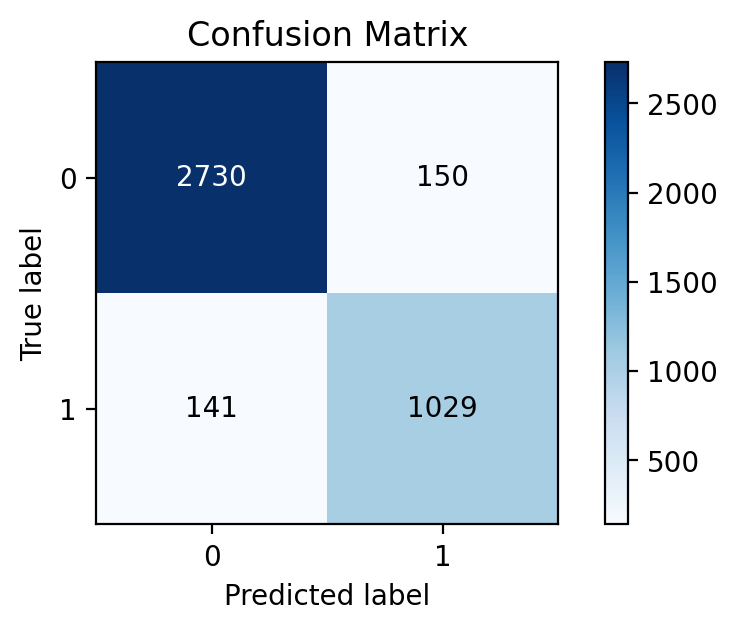

,ROC AUC,Precision,Recall,F1
Random Forest + FastText,0.969176,0.872774,0.879487,0.876117


In [31]:
plt.show(splt.metrics.plot_confusion_matrix(y_test, rf2_pred))
clf_report('Random Forest + FastText', y_test, rf2_pred, rf2_probs)

### 5 - Gradient Boosting

In [32]:
gb = GradientBoostingClassifier(random_state=8)
gb.fit(X_train_vectorized, y_train)

gb_pred = gb.predict(X_test_vectorized)
gb_probs = gb.predict_proba(X_test_vectorized)[:, 1]

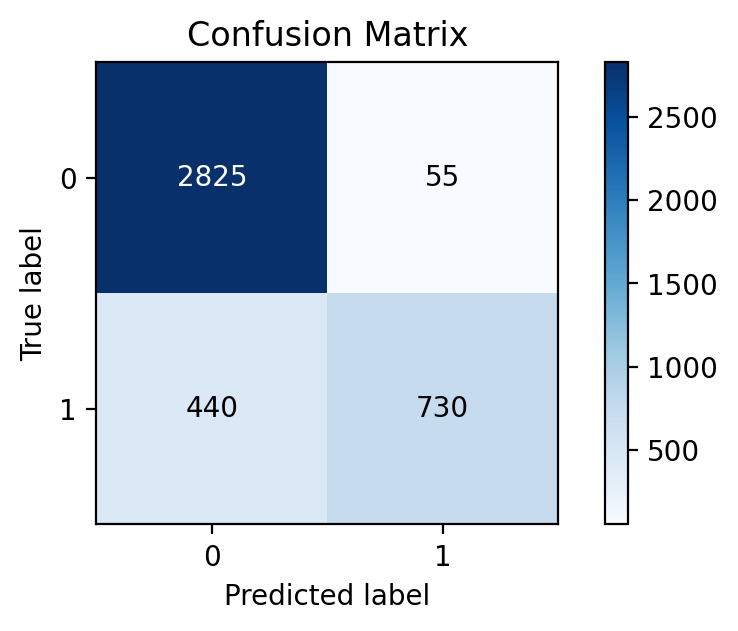

,ROC AUC,Precision,Recall,F1
Gradient Boosting + Tfidf,0.941338,0.929936,0.623932,0.746803


In [33]:
plt.show(splt.metrics.plot_confusion_matrix(y_test, gb_pred))
clf_report('Gradient Boosting + Tfidf', y_test, gb_pred, gb_probs)

In [34]:
gb2 = GradientBoostingClassifier(random_state=8)
gb2.fit(X_train_ft, y_train)

gb2_pred = gb2.predict(X_test_ft)
gb2_probs = gb2.predict_proba(X_test_ft)[:, 1]

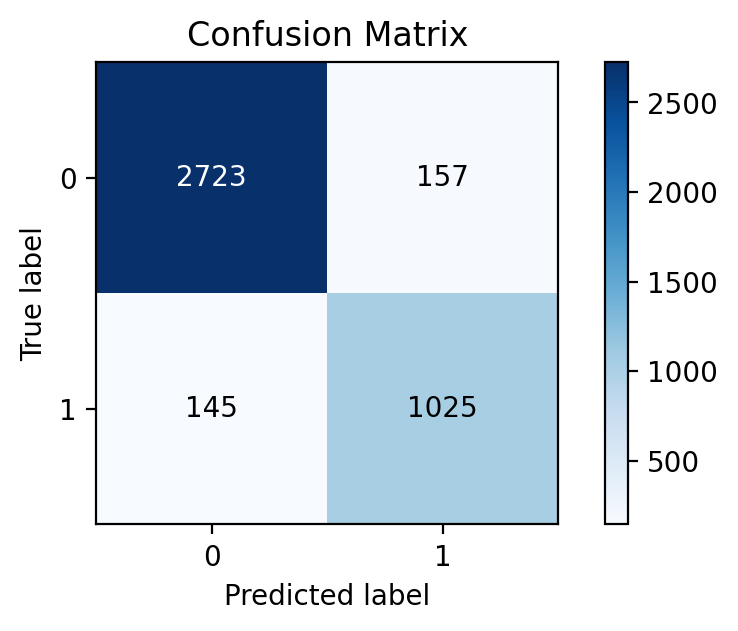

,ROC AUC,Precision,Recall,F1
Gradient Boosting + FastText,0.966332,0.867174,0.876068,0.871599


In [35]:
plt.show(splt.metrics.plot_confusion_matrix(y_test, gb2_pred))
clf_report('Gradient Boosting + FastText', y_test, gb2_pred, gb2_probs)

### Сравнение baseline моделей

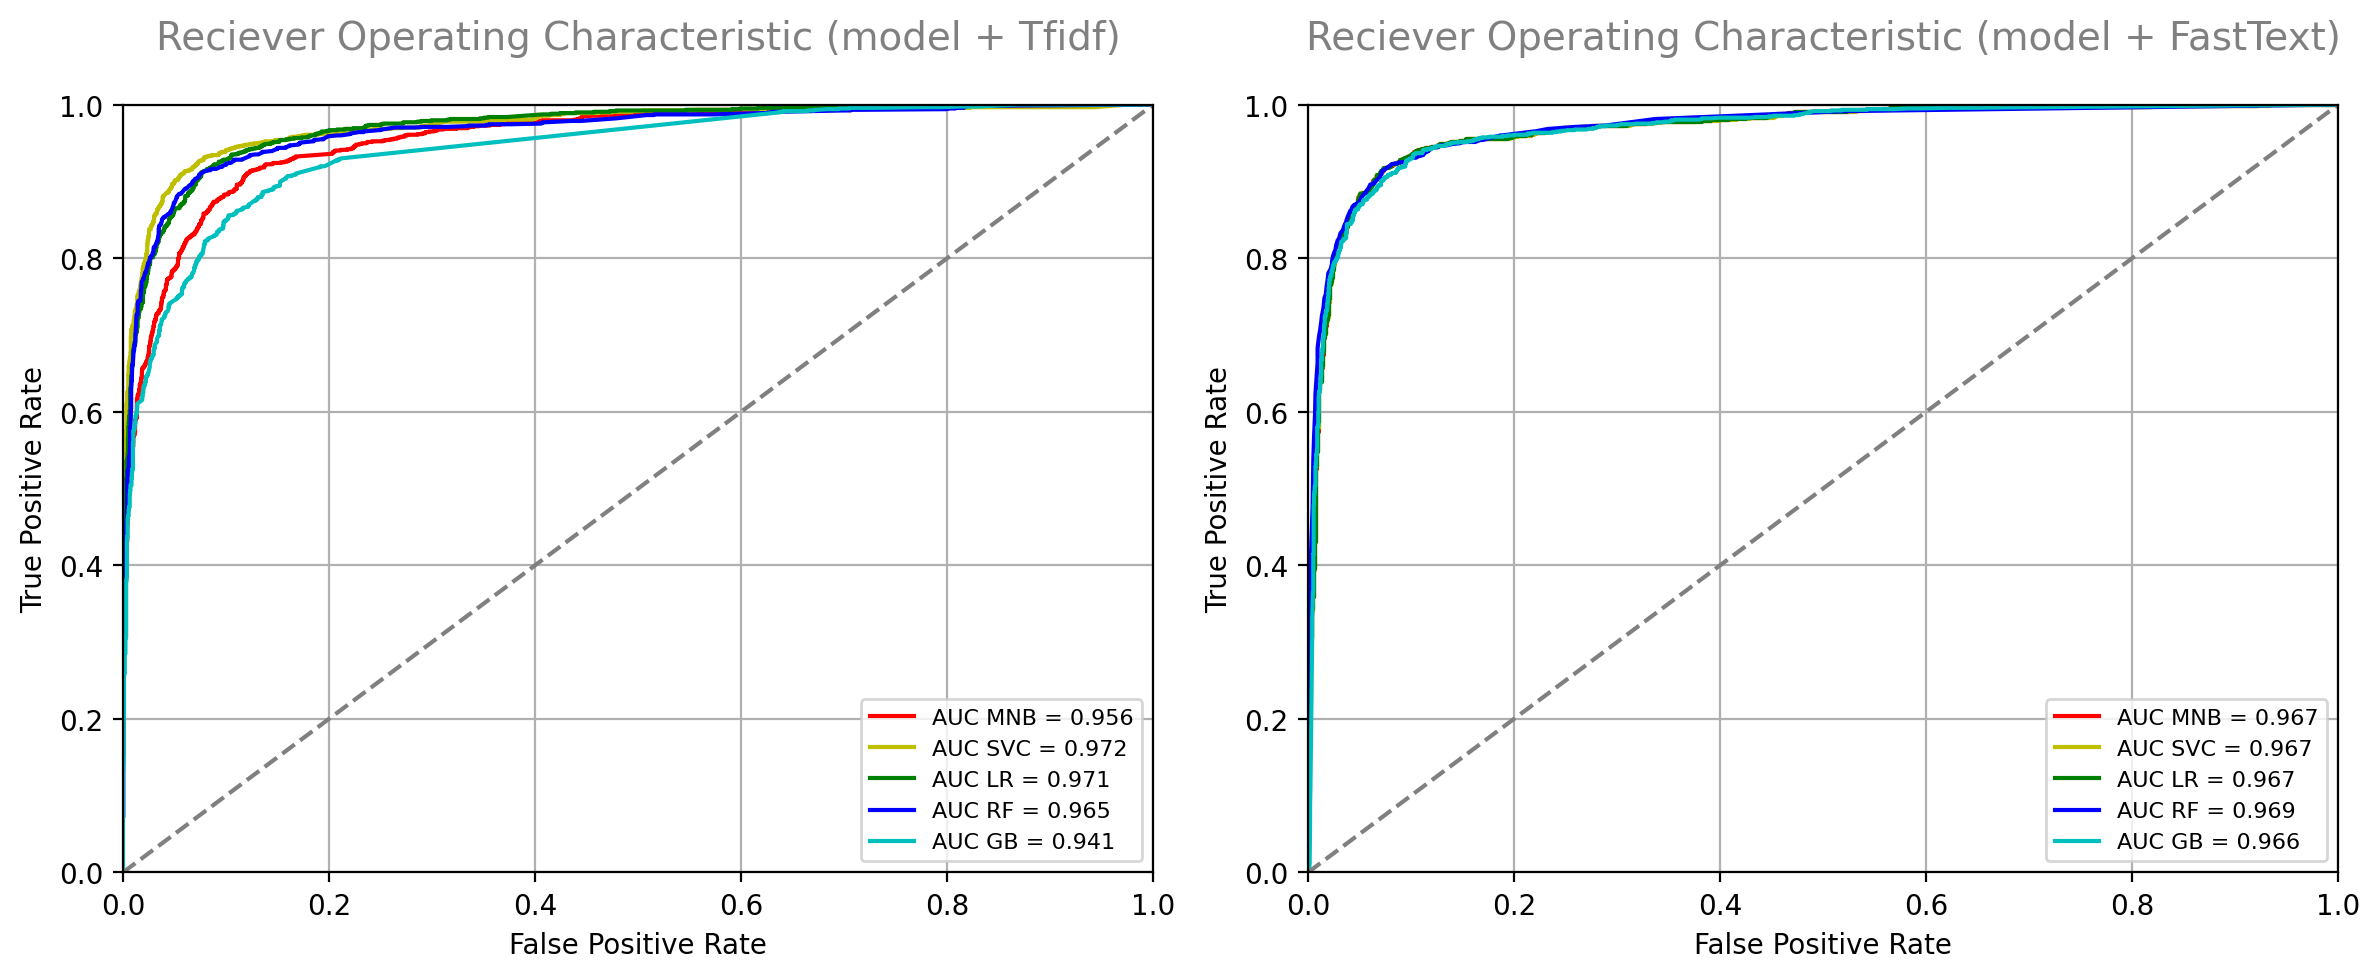

In [57]:
fpr_mnb, tpr_mnb, _ = roc_curve(y_test, mnb_probs)
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)
fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_probs)
roc_auc_svc = auc(fpr_svc, tpr_svc)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probs)
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_mnb2, tpr_mnb2, _ = roc_curve(y_test, mnb2_probs)
roc_auc_mnb2 = auc(fpr_mnb2, tpr_mnb2)
fpr_svc2, tpr_svc2, _ = roc_curve(y_test, svc2_probs)
roc_auc_svc2 = auc(fpr_svc2, tpr_svc2)
fpr_lr2, tpr_lr2, _ = roc_curve(y_test, lr2_probs)
roc_auc_lr2 = auc(fpr_lr2, tpr_lr2)
fpr_rf2, tpr_rf2, _ = roc_curve(y_test, rf2_probs)
roc_auc_rf2 = auc(fpr_rf2, tpr_rf2)
fpr_gb2, tpr_gb2, _ = roc_curve(y_test, gb2_probs)
roc_auc_gb2 = auc(fpr_gb2, tpr_gb2)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(fpr_mnb, tpr_mnb, 'r', label='AUC MNB = %0.3f' % roc_auc_mnb)
axs[0].plot(fpr_svc, tpr_svc, 'y', label='AUC SVC = %0.3f' % roc_auc_svc)
axs[0].plot(fpr_lr, tpr_lr, 'g', label='AUC LR = %0.3f' % roc_auc_lr)
axs[0].plot(fpr_rf, tpr_rf, 'b', label='AUC RF = %0.3f' % roc_auc_rf)
axs[0].plot(fpr_gb, tpr_gb, 'c', label='AUC GB = %0.3f' % roc_auc_gb)
axs[0].plot([0,1], [0,1], color='grey', linestyle='--')

axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, 1])
axs[0].grid(True)
axs[0].legend(loc='lower right', prop={'size': 8})
axs[0].set_title('Reciever Operating Characteristic (model + Tfidf)', pad=20, color='grey', fontsize=14)

axs[1].plot(fpr_mnb2, tpr_mnb2, 'r', label='AUC MNB = %0.3f' % roc_auc_mnb2)
axs[1].plot(fpr_svc2, tpr_svc2, 'y', label='AUC SVC = %0.3f' % roc_auc_svc2)
axs[1].plot(fpr_lr2, tpr_lr2, 'g', label='AUC LR = %0.3f' % roc_auc_lr2)
axs[1].plot(fpr_rf2, tpr_rf2, 'b', label='AUC RF = %0.3f' % roc_auc_rf2)
axs[1].plot(fpr_gb2, tpr_gb2, 'c', label='AUC GB = %0.3f' % roc_auc_gb2)
axs[1].plot([0,1], [0,1], color='grey', linestyle='--')

axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_xlim([0, 1])
axs[1].set_ylim([0, 1])
axs[1].grid(True)
axs[1].legend(loc='lower right', prop={'size': 8})
axs[1].set_title('Reciever Operating Characteristic (model + FastText)', pad=20, color='grey', fontsize=14)

plt.tight_layout();



---

По графику ROC-AUC кривых можно сделать вывод, что в среднем модели, обученные на supervised fasttext эмбеддингах, показывают более высокое качество классификации по сравнению с моделями, обученными на Tfidf-векторах.

Однако в случае SVC и логистической регрессии значение метрики ROC-AUC наоборот снизилось (но увеличился баланс ложноположительных и ложноотрицательных ответов), когда они были обучены на fasttext эмбеддингах.

Наибольший прирост в качестве был достигнут при обучении на эмбеддингах fasttext модели Gradient Boosting.

---



In [58]:
summary_report = pd.concat([
    clf_report('Multinomial NB + Tfidf', y_test, mnb_pred, mnb_probs),
    clf_report('Multinomial NB + FastText', y_test, mnb2_pred, mnb2_probs),
    clf_report('SVC + Tfidf', y_test, svc_pred, svc_probs),
    clf_report('SVC + FastText', y_test, svc2_pred, svc2_probs),
    clf_report('Logistic Regression + Tfidf', y_test, lr_pred, lr_probs),
    clf_report('Logistic Regression + FastText', y_test, lr2_pred, lr2_probs),
    clf_report('Random Forest + Tfidf', y_test, rf_pred, rf_probs),
    clf_report('Random Forest + FastText', y_test, rf2_pred, rf2_probs),
    clf_report('Gradient Boosting + Tfidf', y_test, gb_pred, gb_probs),
    clf_report('Gradient Boosting + FastText', y_test, gb2_pred, gb2_probs)
])
summary_report = summary_report.sort_values(by=['ROC AUC', 'F1'], ascending=False)
(
    summary_report
    .reset_index()
    .rename(columns={'index': 'model'})
    .style
    .hide(axis='index')
    .background_gradient(cmap='PuBu')
    .set_properties(**{'border': '2px solid white'})
    .set_caption('Сравнение метрик baseline моделей')
    .set_table_styles([
        {'selector': 'caption',
        'props': [
            ('font-size', '18px'),
            ('font-weight', 'bold'),
            ('padding', '10px'),
            ('color', 'grey')
            ]}
        ])
)

model,ROC AUC,Precision,Recall,F1
SVC + Tfidf,0.971851,0.919118,0.854701,0.885740
Logistic Regression + Tfidf,0.970593,0.895073,0.838462,0.865843
Random Forest + FastText,0.969176,0.872774,0.879487,0.876117
Logistic Regression + FastText,0.967007,0.883377,0.867521,0.875377
Multinomial NB + FastText,0.966971,0.908497,0.831624,0.868362
SVC + FastText,0.966754,0.883072,0.864957,0.873921
Gradient Boosting + FastText,0.966332,0.867174,0.876068,0.871599
Random Forest + Tfidf,0.965193,0.892857,0.854701,0.873362
Multinomial NB + Tfidf,0.955759,0.828377,0.833333,0.830848
Gradient Boosting + Tfidf,0.941338,0.929936,0.623932,0.746803




---

Гиперпараметры будут подбираться для моделей:

  - SVC + Tfidf
  - Random Forest + FastText
  - Gradient Boosting + FastText


---





## Подбор гиперпараметров

### Random Forest + FastText

In [59]:
rf_params = {
    'n_estimators': np.arange(50, 500, 50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2'],
    'max_depth': np.arange(2, 22, 2),
    'class_weight': ['balanced', 'balanced_subsample']
}

In [60]:
gs_rf = RandomizedSearchCV(rf2, rf_params, n_iter=100, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
gs_rf.fit(X_train_ft, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   scoring='roc_auc', verbose=1)

In [61]:
gs_rf.best_score_, gs_rf.best_params_

(0.9818189383319104,
 {'n_estimators': 450,
  'max_features': 'sqrt',
  'max_depth': 8,
  'criterion': 'entropy',
  'class_weight': 'balanced_subsample'})

In [62]:
# (0.9818189383319104,
#  {'n_estimators': 450,
#   'max_features': 'sqrt',
#   'max_depth': 8,
#   'criterion': 'entropy',
#   'class_weight': 'balanced_subsample'})

In [63]:
best_rf_ft = RandomForestClassifier(**gs_rf.best_params_)
best_rf_ft.fit(X_train_ft, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=8, n_estimators=450)

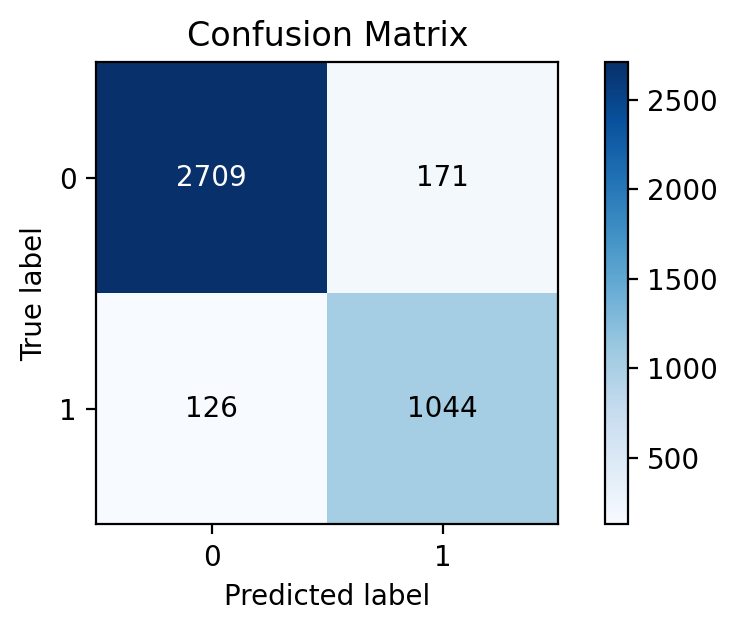

,ROC AUC,Precision,Recall,F1
Random Forest + FastText,0.970023,0.859259,0.892308,0.875472


In [64]:
gs_rf_pred = best_rf_ft.predict(X_test_ft)
gs_rf_probs = best_rf_ft.predict_proba(X_test_ft)[:, 1]

plt.show(splt.metrics.plot_confusion_matrix(y_test, gs_rf_pred))
clf_report('Random Forest + FastText', y_test, gs_rf_pred, gs_rf_probs)

In [65]:
# joblib.dump(gs_rf.best_estimator_, 'best_rf_ft.pkl')

### SVC + Tfidf

In [36]:
svc_params = {
    'C': [.01, .1, 1, 5, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [.01, .1, 1, 5, 10, 100]
}

In [ ]:
gs_svc = RandomizedSearchCV(svc, svc_params, n_iter=30, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
gs_svc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [ ]:
gs_svc.best_score_, gs_svc.best_params_

In [ ]:
best_svc_tfidf = SVC(**gs_svc.best_params_)
best_svc_tfidf.fit(X_train_scaled, y_train)

In [ ]:
gs_svc_pred = best_svc_tfidf.predict(X_test_scaled)
gs_svc_probs = best_svc_tfidf.predict_proba(X_test_scaled)[:, 1]

plt.show(splt.metrics.plot_confusion_matrix(y_test, gs_svc_pred))
clf_report('SVC + Tfidf', y_test, gs_svc_pred, gs_svc_probs)

### Gradient Boosting + FastText

In [ ]:
gb_params = {
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [.001, .01, .1, .3]
}

In [ ]:
gs_gb = RandomizedSearchCV(gb2, gb_params, n_iter=100, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
gs_gb.fit(X_train_ft, y_train)

In [ ]:
gs_gb.best_score_, gs_gb.best_params_

In [ ]:
best_gb_ft = GradientBoostingClassifier(**gs_gb.best_params_)
best_gb_ft.fit(X_train_ft, y_train)

In [ ]:
gs_gb_pred = best_gb_ft.predict(X_test_ft)
gs_gb_probs = best_gb_ft.predict_proba(X_test_ft)[:, 1]

plt.show(splt.metrics.plot_confusion_matrix(y_test, gs_gb_pred))
clf_report('Gradient Boosting + FastText', y_test, gs_gb_pred, gs_gb_probs)

## Предикт на тесте

In [ ]:
test_df = pd.read_csv('test_preproc.csv')